<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-outliers/blob/ML_Models/LSTM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing libraries

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , mean_absolute_percentage_error
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from statsmodels.tsa.seasonal import seasonal_decompose

sns.set(style="whitegrid")


##loading dataset

In [4]:
df = pd.read_csv('streamflow_filled.csv')
df.head()

,Date,Unnamed: 0,Year,Month,Day,Q (m3/s)
0,1967-01-01,11963,1967,1,1,2690.0
1,1967-01-02,11964,1967,1,2,2650.0
2,1967-01-03,11965,1967,1,3,2650.0
3,1967-01-04,11966,1967,1,4,2610.0
4,1967-01-05,11967,1967,1,5,2570.0


##exploring data

In [5]:
df.isnull().sum()

,0
Date,0
Unnamed: 0,0
Year,0
Month,0
Day,0
Q (m3/s),0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        18628 non-null  object 
 1   Unnamed: 0  18628 non-null  int64  
 2   Year        18628 non-null  int64  
 3   Month       18628 non-null  int64  
 4   Day         18628 non-null  int64  
 5   Q (m3/s)    18628 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


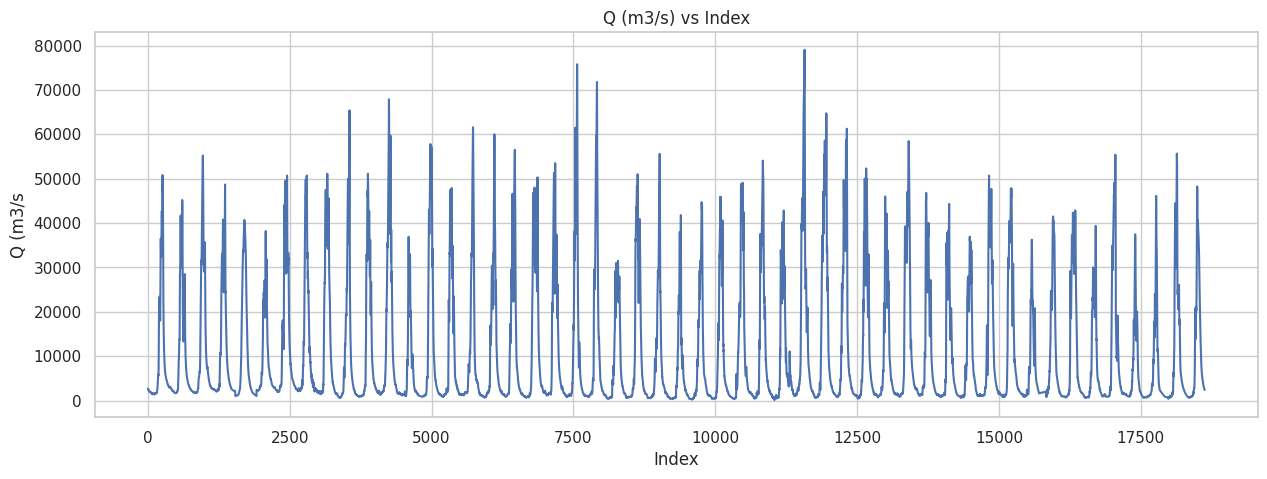

In [6]:
df.info()
plt.figure(figsize=(15,5))
plt.plot(df.index , df['Q (m3/s)'] )
plt.title('Q (m3/s) vs Index')
plt.xlabel('Index')
plt.ylabel('Q (m3/s')
plt.show()

Monthly dataset

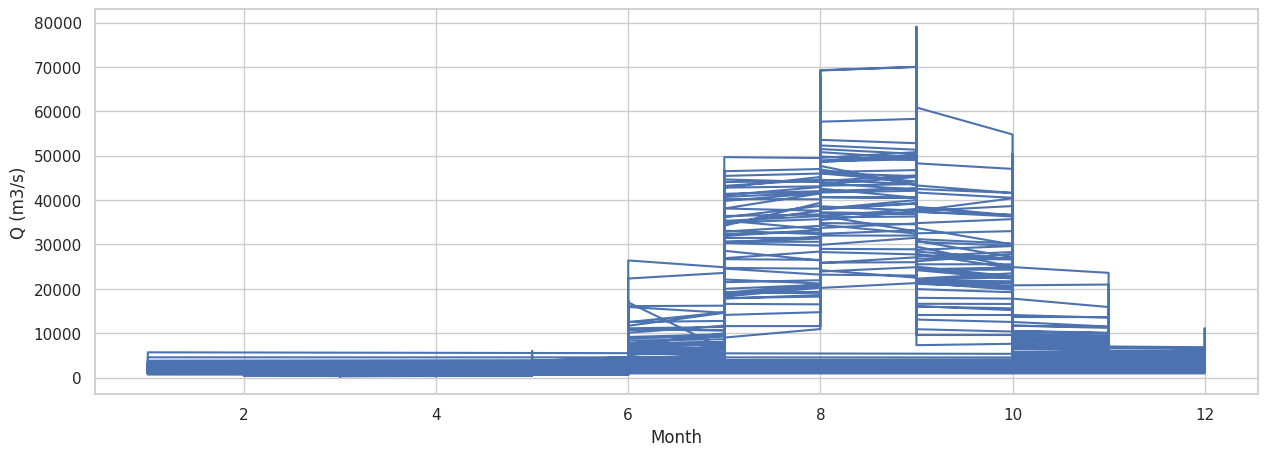

In [7]:
plt.figure(figsize=(15,5))
plt.plot(df.Month , df['Q (m3/s)'] )
plt.xlabel('Month')
plt.ylabel('Q (m3/s)')
plt.show()

In [8]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')

df = df.sort_index()

monthly = df.resample('ME').mean()
monthly.head()


,Unnamed: 0,Year,Month,Day,Q (m3/s)
Date,,,,,
1967-01-31,11978.0,1967.0,1.0,16.0,2309.354839
1967-02-28,12007.5,1967.0,2.0,14.5,1950.714286
1967-03-31,12037.0,1967.0,3.0,16.0,1550.967742
1967-04-30,12067.5,1967.0,4.0,15.5,1527.666667
1967-05-31,12098.0,1967.0,5.0,16.0,1615.161290


<Figure size 1500x500 with 0 Axes>

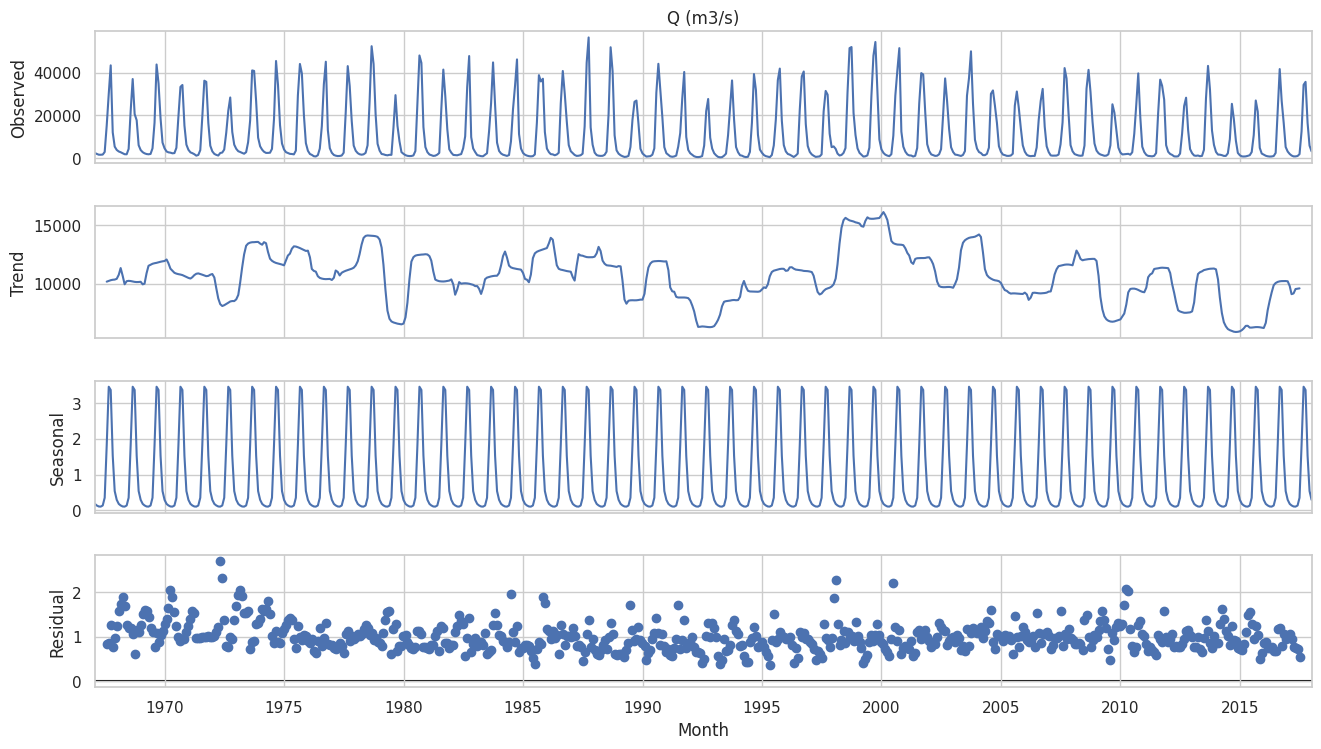

In [9]:
plt.figure(figsize=(15,5))
seasons = seasonal_decompose(monthly['Q (m3/s)'], model='multiplicative' , period = 12)
fig = seasons.plot()
fig.set_size_inches(15, 8)
fig.axes[0].set_ylabel("Observed")
fig.axes[1].set_ylabel("Trend")
fig.axes[2].set_ylabel("Seasonal")
fig.axes[3].set_ylabel("Residual")
fig.axes[3].set_xlabel("Month")

plt.show()

Select target variable (Q m³/s)

In [10]:
target_col = 'Q (m3/s)'
series = df[target_col].astype(float)

Plot the time series

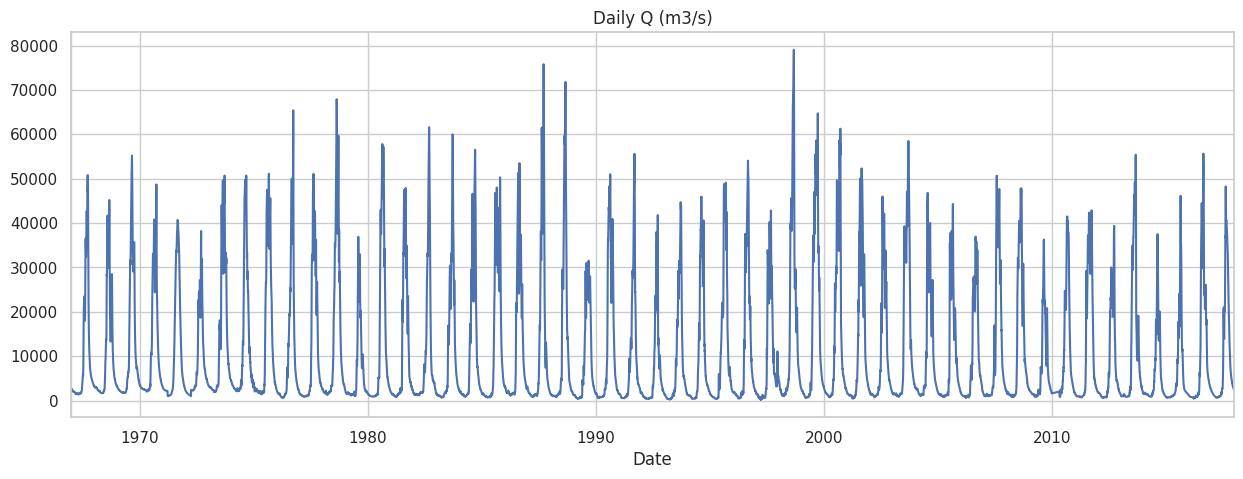

In [11]:
series.plot(figsize=(15,5), title = 'Daily Q (m3/s)')
plt.show()

###LSTMs work better with scaled values.

In [12]:
scaler = MinMaxScaler()
series_scaled = scaler.fit_transform(series.values.reshape(-1,1))


###Creating input series

In [13]:
SEQ_LEN  = 30
def create_sequences(data , seq_len):
  X,y = [] ,[]
  for i in range(len(data) - seq_len):
    X.append(data[i:i+seq_len])
    y.append(data[i+seq_len])
  return np.array(X) , np.array(y)
X,y = create_sequences(series_scaled , SEQ_LEN)
X.shape , y.shape



((18598, 30, 1), (18598, 1))

###Splitting the data

In [14]:
split = int(0.85 *len(X))
X_train , y_train = X[:split] , y[:split]
X_test , y_test = X[split:] , y[split:]


##model

In [15]:
tf.random.set_seed(42)
model = Sequential([
    LSTM(64, input_shape=(SEQ_LEN, 1), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,009 (74.25 KB)

 Trainable params: 19,009 (74.25 KB)

 Non-trainable params: 0 (0.00 B)

###Train

In [16]:
es = EarlyStopping(monitor="val_loss",
                                    patience=5,
                                    restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[es]
)

Epoch 1/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0072 - mae: 0.0405 - val_loss: 3.1482e-04 - val_mae: 0.0086
Epoch 2/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 6.1863e-04 - mae: 0.0138 - val_loss: 2.1469e-04 - val_mae: 0.0103
Epoch 3/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 3.7227e-04 - mae: 0.0116 - val_loss: 1.2197e-04 - val_mae: 0.0060
Epoch 4/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.9818e-04 - mae: 0.0103 - val_loss: 1.5419e-04 - val_mae: 0.0073
Epoch 5/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.7444e-04 - mae: 0.0102 - val_loss: 8.7150e-05 - val_mae: 0.0056
Epoch 6/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 2.4626e-04 - mae: 0.0098 - val_loss: 7.9875e-05 - val_mae: 0.0051
Epoch 7/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 2.1733e-04 - mae: 0.0095 - val_loss: 6.7229e-05 - val_mae: 0.0046
Epoch 8/200
494/494 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 1.9238e-04 - mae: 0.0087 - val_loss: 9.9926e-05 - va

###Evaluating the model

In [25]:
pred_scaled = model.predict(X_test)
pred = scaler.inverse_transform(pred_scaled)
y_test_inv = scaler.inverse_transform(y_test)
mae = mean_absolute_error(y_test_inv, pred)
maep = mean_absolute_percentage_error(y_test_inv, pred)
mse = mean_squared_error(y_test_inv, pred)
rmse = math.sqrt(mse)

print("MAE:", mae)
print("MAEP:" , maep)
print("MSE:", mse)
print("RMSE:", rmse)

88/88 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAE: 282.3160507348274
MAEP: 0.049881005115710836
MSE: 293181.4948558167
RMSE: 541.4623669802147


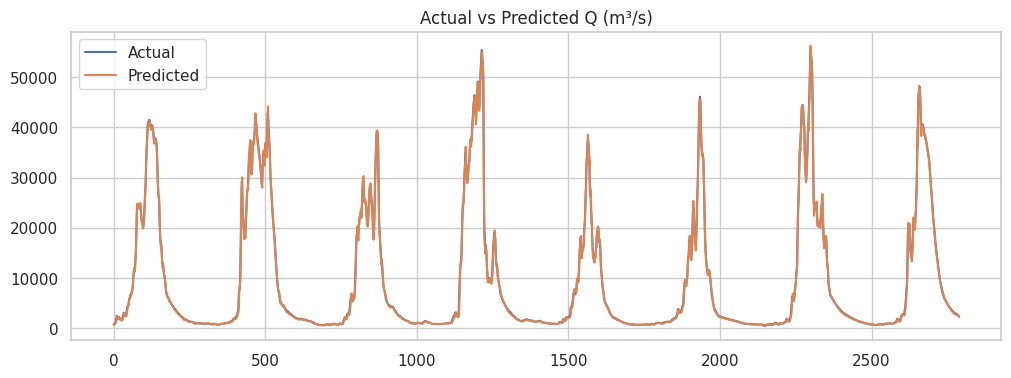

In [18]:
plt.figure(figsize=(12,4))
plt.plot(y_test_inv, label='Actual')
plt.plot(pred, label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Q (m³/s)")
plt.show()


###Forecast future values

In [28]:
def forecast_future(model, last_sequence, n):
    seq = last_sequence.copy()
    preds = []
    for _ in range(n):
        p = model.predict(seq.reshape(1, SEQ_LEN, 1))[0]
        preds.append(p)
        seq = np.vstack([seq[1:], p])
    return np.array(preds)

last_seq = series_scaled[-SEQ_LEN:]
future_scaled = forecast_future(model, last_seq, 365)
future = scaler.inverse_transform(future_scaled)
future


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━

array([[2214.8127 ],
       [2117.078  ],
       [1993.065  ],
       [1869.6262 ],
       [1749.2375 ],
       [1632.2443 ],
       [1519.3733 ],
       [1411.4536 ],
       [1309.1744 ],
       [1213.0182 ],
       [1123.2734 ],
       [1040.0647 ],
       [ 963.3846 ],
       [ 893.1206 ],
       [ 829.08124],
       [ 771.0127 ],
       [ 718.6152 ],
       [ 671.56366],
       [ 629.50977],
       [ 592.0991 ],
       [ 558.97437],
       [ 529.78345],
       [ 504.18323],
       [ 481.84518],
       [ 462.45374],
       [ 445.7133 ],
       [ 431.34467],
       [ 419.0899 ],
       [ 408.70984],
       [ 399.9823 ],
       [ 392.70868],
       [ 386.70383],
       [ 381.80264],
       [ 377.857  ],
       [ 374.73175],
       [ 372.307  ],
       [ 370.47818],
       [ 369.15002],
       [ 368.24268],
       [ 367.6797 ],
       [ 367.40228],
       [ 367.3541 ],
       [ 367.48868],
       [ 367.76547],
       [ 368.151  ],
       [ 368.61642],
       [ 369.13828],
       [ 369.

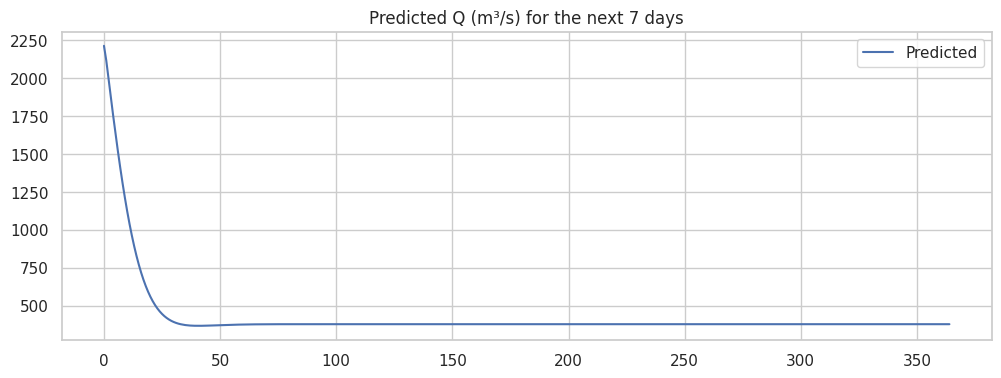

In [29]:
plt.figure(figsize=(12,4))
plt.plot(future, label='Predicted')
plt.legend()
plt.title("Predicted Q (m³/s) for the next 7 days")
plt.show()

###Plot of the last 30 real values + next 7 predicted values

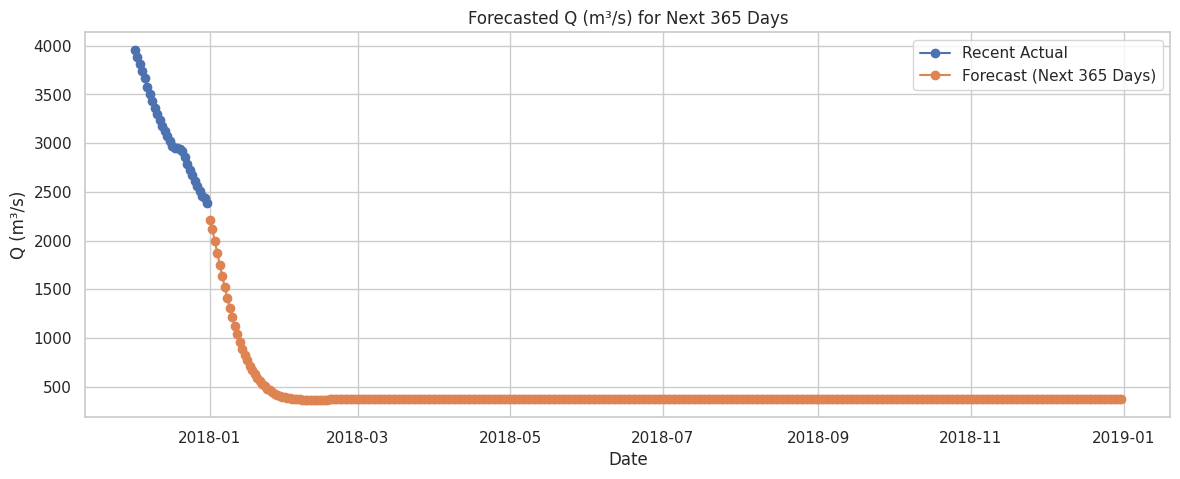

In [30]:
history_days = 30
recent_actual = series[-history_days:]

last_date = series.index[-1]

# Generate 1 year of daily dates
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=365)

# Convert predictions to a pandas Series
future_series = pd.Series(future.flatten(), index=future_dates)

plt.figure(figsize=(14,5))
plt.plot(recent_actual.index, recent_actual.values, label="Recent Actual", marker='o')

# Plot 1-year forecast
plt.plot(future_series.index, future_series.values, label="Forecast (Next 365 Days)", marker='o')

plt.title("Forecasted Q (m³/s) for Next 365 Days")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()


###single continuous plot (acutal one  + predicted)

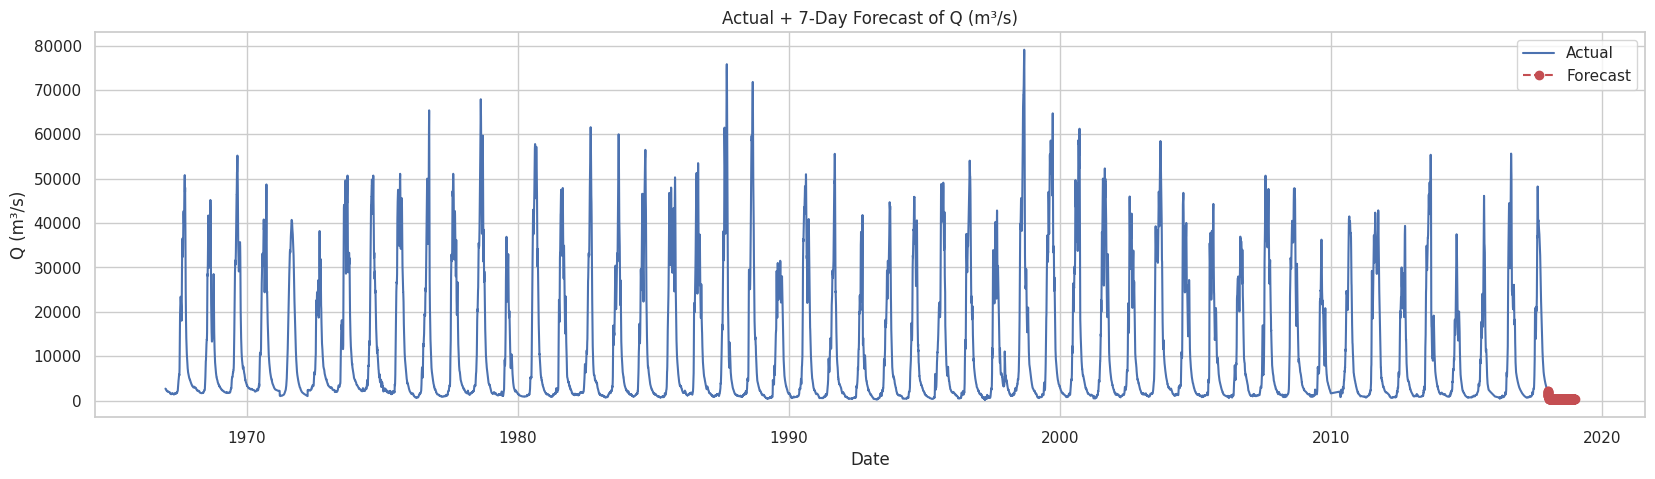

In [31]:
plt.figure(figsize=(20,5))
plt.plot(series.index, series.values, label="Actual")
plt.plot(future_dates, future.flatten(), 'r--o', label="Forecast")
plt.title("Actual + 7-Day Forecast of Q (m³/s)")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()


In [33]:
def forecast_future(model, last_sequence, n):
    seq = last_sequence.copy().reshape(-1)
    preds = []
    for _ in range(n):
        p = model.predict(seq.reshape(1, SEQ_LEN, 1), verbose=0)[0,0]
        preds.append([p])
        seq = np.concatenate([seq[1:], np.array([p])])
    return np.array(preds)

In [34]:
last_seq = series_scaled[-SEQ_LEN:].reshape(-1)

In [36]:
days_to_predict = 365
future_scaled = forecast_future(model, last_seq, days_to_predict)

In [38]:
future = scaler.inverse_transform(future_scaled)    # (365,1)
future_flat = future.flatten()

In [39]:
print("future_scaled.shape:", future_scaled.shape)
print("future.shape:", future.shape)
print("first 5 preds (original units):", future_flat[:5])

future_scaled.shape: (365, 1)
future.shape: (365, 1)
first 5 preds (original units): [2214.8127 2117.078  1993.065  1869.6262 1749.2375]


In [40]:
print("future_scaled.shape:", future_scaled.shape)
print("future.shape:", future.shape)
print("first 5 preds (original units):", future_flat[:5])

future_scaled.shape: (365, 1)
future.shape: (365, 1)
first 5 preds (original units): [2214.8127 2117.078  1993.065  1869.6262 1749.2375]


In [41]:
last_date = series.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=days_to_predict, freq='D')
future_series = pd.Series(future_flat, index=future_dates)


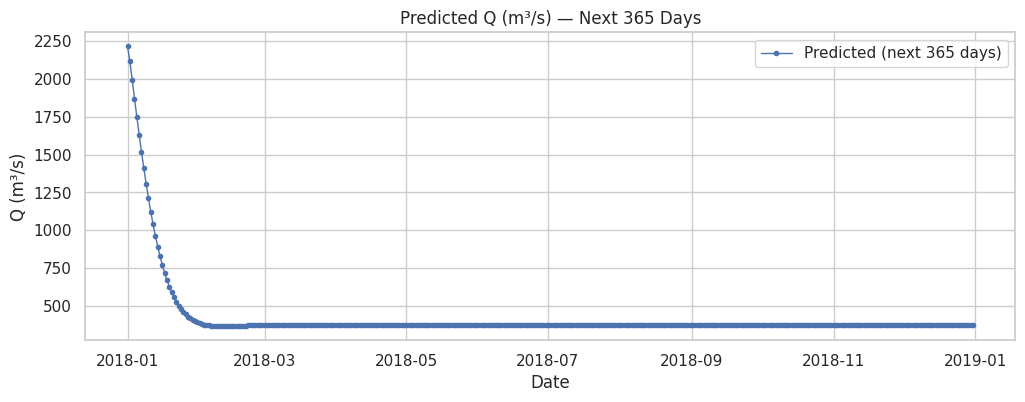

In [42]:
plt.figure(figsize=(12,4))
plt.plot(future_dates, future_flat, label='Predicted (next 365 days)', marker='o', markersize=3, linewidth=1)
plt.title("Predicted Q (m³/s) — Next 365 Days")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()

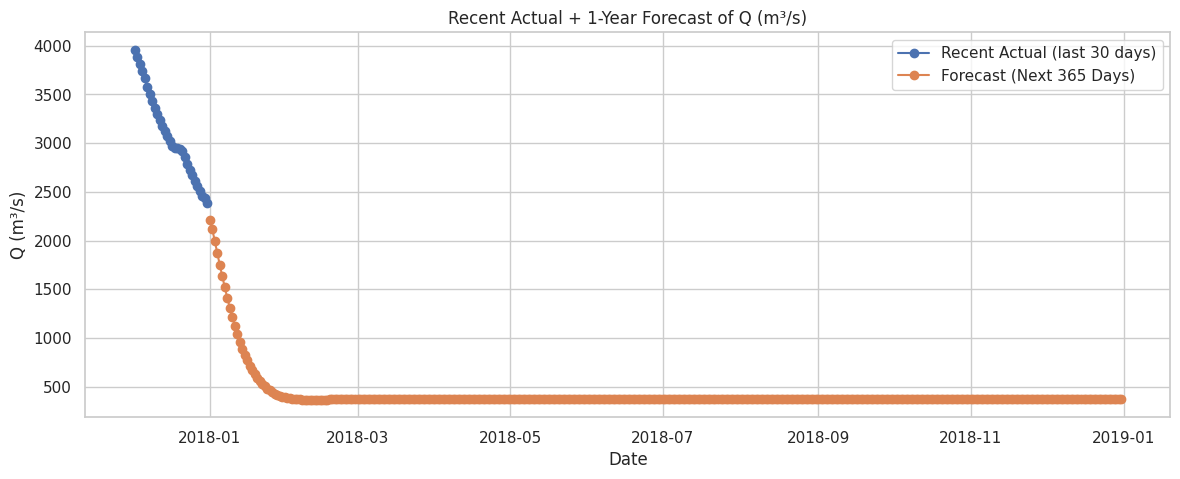

In [43]:
history_days = 30
recent_actual = series[-history_days:]

plt.figure(figsize=(14,5))
plt.plot(recent_actual.index, recent_actual.values, label="Recent Actual (last 30 days)", marker='o')
plt.plot(future_series.index, future_series.values, label="Forecast (Next 365 Days)", marker='o')
plt.title("Recent Actual + 1-Year Forecast of Q (m³/s)")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()


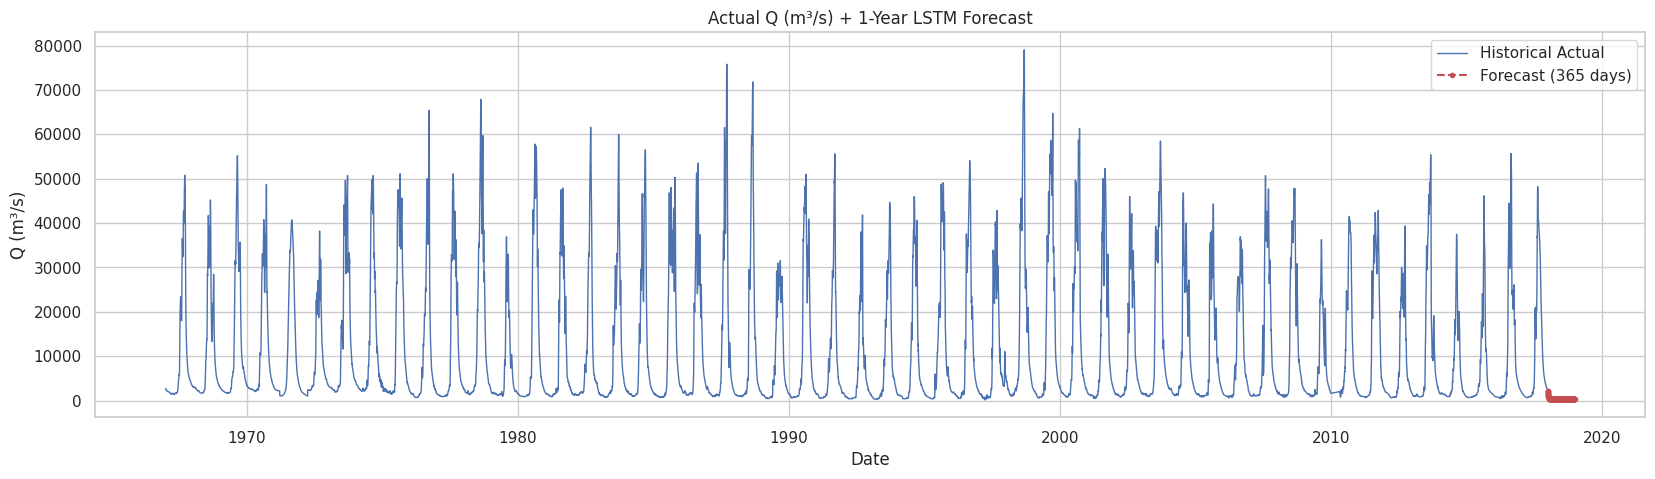

In [44]:
plt.figure(figsize=(20,5))
plt.plot(series.index, series.values, label="Historical Actual", linewidth=1)
plt.plot(future_series.index, future_series.values, 'r--o', label="Forecast (365 days)", markersize=3)
plt.title("Actual Q (m³/s) + 1-Year LSTM Forecast")
plt.xlabel("Date")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()